# CMA/ES MODIFIED. Sigma Base, 7th try: LL92, fixed cov, lapse + sigma_base

Same as 3Try, with LL92

Trying to find the sweep spot between LL90 which seems a bit too aggressively avoiding datapoints, and LL->95, which just have lapse_rate=0.15... 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa


# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
# import submitpbs
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo

## Reload data

In [3]:
%cd /nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_bays09_ll92_7try_Mratiosigmaxsigmabaselinelapserate_repetitions3_170816
results_optim_tracking = np.load('outputs/cmaes_alliter_tracking-<module>-3e4f3bc2-6692-4783-9e0e-5cd36221f45b.npy').item()

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_bays09_ll92_7try_Mratiosigmaxsigmabaselinelapserate_repetitions3_170816


In [4]:
candidates_parameters = np.array(results_optim_tracking['candidates'])
fitness = np.array(results_optim_tracking['fitness'])
parameter_names_sorted = results_optim_tracking['parameter_names_sorted']

In [5]:
parameter_names_sorted

['M', 'lapse_rate', 'ratio_conj', 'sigma_baseline', 'sigmax']

In [6]:
metric = 'dist_nll90'

df_all_fits = pd.DataFrame.from_items([('step', np.arange(fitness.size)), 
                                       (metric, np.ma.masked_greater(fitness.flatten(), 1e8))] + 
                                      [(param, candidates_parameters[:, param_i]) 
                                           for param_i, param in enumerate(parameter_names_sorted)])

In [7]:
# Fix M and ratio_conj
M_corrected, ratio_corrected = utils.fix_M_ratioconj(df_all_fits['M'], df_all_fits['ratio_conj'])
df_all_fits.loc[:, 'M'] = M_corrected
df_all_fits.loc[:, 'ratio_conj'] = ratio_corrected

In [8]:
# Filter rows where LL > cutoff value and remove lapse_rate > cutoff
LL_max_cutoff = 20000

df_best_fits = df_all_fits[df_all_fits[metric] < LL_max_cutoff]

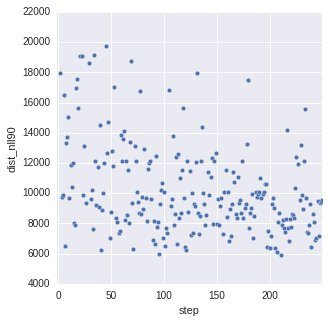

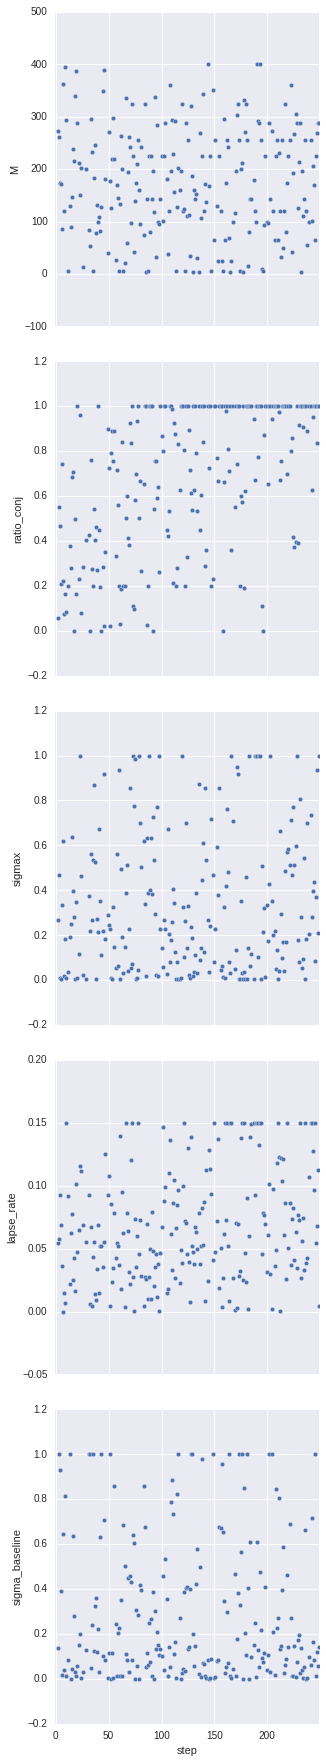

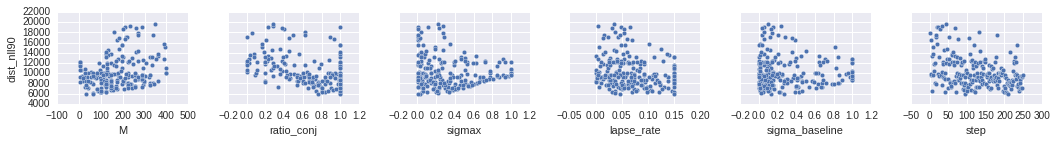

In [9]:
# Learning curve
g = sns.pairplot(df_best_fits,
             y_vars=[metric],
             x_vars=['step'],
             size=5
            )
g.set(xlim=(-1, df_best_fits['step'].max())
     )


# Check training of parameters
g = sns.pairplot(df_best_fits,
             y_vars=['M', 'ratio_conj', 'sigmax', 'lapse_rate', 'sigma_baseline'],
             x_vars=['step'],
             size=5
            )
g.set(xlim=(-1, df_best_fits['step'].max()))


# Check parameters effects
sns.pairplot(df_best_fits,
             x_vars=['M', 'ratio_conj', 'sigmax', 'lapse_rate', 'sigma_baseline', 'step'],
             y_vars=[metric],
            )



## Check parameters values obtained

In [ ]:
df_bestparams = df_best_fits.sort_values(by='step', ascending=False).head(100).median()
df_bestparams

In [ ]:
%run /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/experimentlauncher.py \
--action_to_do launcher_do_fitexperiment_allmetrics --inference_method none  --num_samples 200  --renormalize_sigma \
--autoset_parameters --code_type mixed  --sigmay 0.00001  --experiment_id bays09 \
--lapse_rate {df_bestparams['lapse_rate']} --M {int(df_bestparams['M'])} --sigmax {df_bestparams['sigmax']} \
--ratio_conj {df_bestparams['ratio_conj']} --sigma_baseline {df_bestparams['sigma_baseline']} \
--filter_datapoints_size 1500 --filter_datapoints_selection 'random'

In [ ]:
plots_fit_exp = PlotsFitExperimentAllTPaperTheo(fit_exp)

In [ ]:
axesFig2 = plots_fit_exp.plots_distrib_errors_data_fig2()

In [ ]:
axesFig5 = plots_fit_exp.plots_distrib_errors_fig5()

In [ ]:
_ = plots_fit_exp.plots_KS_comparison_fig2fig5(bins=100)

In [ ]:
axesFig6Fig13 = plots_fit_exp.plots_memmixtcurves_fig6fig13(num_repetitions=5, use_cache=True)

# ANALYSE ME: check if LL92 is good enough

Then start new Subject fits with it to compare.